# Matched Filter Pipeline Demo (PRISMA)

This notebook mirrors the operational CH$\_4$ pipeline on a PRISMA L1 scene to show how the matched filter, LUT targets, and propagated noise cubes yield concentration and uncertainty rasters.

**Pipeline stages**
1. Bootstrap the repository context to import `scripts/` modules from the notebook.
2. Configure the PRISMA inputs (L1/L2C files, DEM, LUT, SNR reference) and matched-filter hyperparameters.
3. Execute `prisma_pipeline.ch4_detection`, which performs radiance calibration, geometric corrections, background modelling, and the matched-filter solve $w = \Sigma^{-1}(t-\mu)$ followed by $\Delta X = w^\top (L-\mu)$.
4. Inspect the RGB, concentration, and $\sigma_{RMN}$ raster outputs to interpret plume detections versus instrument noise limits.


## 1. Bootstrap repository context
Resolve the notebook location, climb to the repository root, and register it on `PYTHONPATH` so this notebook reuses the same pipeline code as the command-line tools.


In [4]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / 'scripts').exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / 'scripts').exists():
    raise RuntimeError('Could not locate repository root containing scripts directory.')

os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print(f'Notebook root: {NOTEBOOK_ROOT}')
print(f'Repository root: {REPO_ROOT}')

Notebook root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks
Repository root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas


## 2. Scene configuration and assumptions
Set the PRISMA L1 (radiance) and L2C (geometry) products, DEM, LUT, and SNR reference paths alongside the matched-filter parameters. The spectral window (2.1-2.45 um) isolates methane absorption lines, `k` controls the number of k-means clusters for background covariance, and `save_rads=False` avoids persisting intermediate cubes. The LUT is parametrised by solar zenith, atmospheric water vapour, and terrain height derived from the metadata.


In [5]:
SENSOR = 'prisma'
PIPELINE_OUTPUT_ROOT = NOTEBOOK_ROOT / 'outputs' / 'pipeline_demo' / SENSOR
SELECTED_MF_MODE = 'full-column'  # Options: 'srf-column', 'full-column', 'advanced', 'jpl'

PRISMA_SCENES = {
    'ekizak_plume_prisma': {
        'l1': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Ekizak_Turkmenistan_20220912/20220912072502_20220912072506/PRS_L1_STD_OFFL_20220912072502_20220912072506_0001.zip'),
        'l2c': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Ekizak_Turkmenistan_20220912/20220912072502_20220912072506/PRS_L2C_STD_20220912072502_20220912072506_0001.zip'),
        'dem': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
        'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
        'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'prisma' / '20200401085313' / 'snr_reference_columnwise.npz',
        'output_dir': PIPELINE_OUTPUT_ROOT / 'ekizak_plume',
        'min_wavelength': 2100.0,
        'max_wavelength': 2450.0,
        'k': 1,
        'mf_mode': SELECTED_MF_MODE,
    },
    'northern_state_background_prisma': {
        'l1': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip'),
        'l2c': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'),
        'dem': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
        'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
        'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'prisma' / '20200401085313' / 'snr_reference_columnwise.npz',
        'output_dir': PIPELINE_OUTPUT_ROOT / 'northern_state_background',
        'min_wavelength': 2100.0,
        'max_wavelength': 2450.0,
        'k': 1,
        'mf_mode': SELECTED_MF_MODE,
    },
    'Turkmenistan_20240911_prisma': {
        'l1': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Turkmenistan_20240911/prisma/PRS_L1_STD_OFFL_20240911071147_20240911071151_0001.zip'),
        'l2c': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Turkmenistan_20240911/prisma/PRS_L2C_STD_20240911071147_20240911071151_0001.zip'),
        'dem': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
        'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
        'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'prisma' / '20200401085313' / 'snr_reference_columnwise.npz',
        'output_dir': PIPELINE_OUTPUT_ROOT / 'Turkmenistan_20240911_prisma',
        'min_wavelength': 2100.0,
        'max_wavelength': 2450.0,
        'k': 1,
        'mf_mode': SELECTED_MF_MODE,
    },
    'Ehrenberg_validation_prisma': {
        'l1': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Ehrenberg/20211021182310/PRS_L1_STD_OFFL_20211021182310_20211021182315_0001.zip'),
        'l2c': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Ehrenberg/20211021182310/PRS_L2C_STD_20211021182310_20211021182315_0001.zip'),
        'dem': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
        'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
        'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'prisma' / '20200401085313' / 'snr_reference_columnwise.npz',
        'output_dir': PIPELINE_OUTPUT_ROOT / 'Ehrenberg_validation_prisma',
        'min_wavelength': 1000.0,
        'max_wavelength': 2500.0,
        'k': 1,
        'mf_mode': SELECTED_MF_MODE,
    },
}

SELECTED_SCENE = 'Turkmenistan_20240911_prisma'  # switch to 'northern_state_background' for the methane-free case
CONFIG = PRISMA_SCENES[SELECTED_SCENE]

CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
CONFIG


{'l1': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Turkmenistan_20240911/prisma/PRS_L1_STD_OFFL_20240911071147_20240911071151_0001.zip'),
 'l2c': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Turkmenistan_20240911/prisma/PRS_L2C_STD_20240911071147_20240911071151_0001.zip'),
 'dem': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
 'lut': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
 'snr_reference': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313/snr_reference_columnwise.npz'),
 'output_dir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hyg

## 3. Run the matched-filter pipeline
`prisma_pipeline.ch4_detection` unpacks the L1 archive if needed, performs radiance calibration, computes background statistics, synthesises a target spectrum from the LUT, and evaluates the matched filter / uncertainty propagation. The solver assumes column-wise covariance, yielding $\Delta X$ in ppm·m plus $\sigma_{RMN}$ derived from the supplied SNR reference.


In [6]:
from scripts.pipelines import prisma_pipeline

prisma_pipeline.ch4_detection(
    L1_file=str(CONFIG['l1']),
    L2C_file=str(CONFIG['l2c']),
    dem_file=str(CONFIG['dem']),
    lut_file=str(CONFIG['lut']),
    output_dir=str(CONFIG['output_dir']),
    min_wavelength=CONFIG['min_wavelength'],
    max_wavelength=CONFIG['max_wavelength'],
    k=CONFIG['k'],
    mf_mode=CONFIG.get('mf_mode', 'srf-column'),
    save_rads=False,
    snr_reference_path=str(CONFIG['snr_reference']),
)
print('Pipeline run complete.')

Sun Zenith Angle (degrees): 37.4878
Mean Water Vapor (g/cm^2): 2.0017972
Mean Elevation within Bounding Box in Km: 0.004771573543548584


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Creating output file that is 1275P x 967L.
Processing temp_output.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1275P x 967L.
Processing temp_output.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1275P x 967L.
Processing temp_output.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1275P x 967L.
Processing temp_output.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Report di elaborazione PRISMA generato in: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Turkmenistan_20240911_prisma/processing_report.txt
Pipeline run complete.


## 4. Load and interpret retrieval outputs
Locate the `_rgb`, `_MF`, and `_MF_uncertainty` rasters inside the pipeline output directory, read them with GDAL, and display: RGB composite for scene context, matched-filter enhancement (ppm·m), and propagated instrument noise. High enhancements paired with low $\sigma_{RMN}$ indicate confident detections, whereas regions where $\Delta X$ is comparable to $\sigma_{RMN}$ are noise-limited.


RGB: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Turkmenistan_20240911_prisma/PRS_L1_STD_OFFL_20240911071147_20240911071151_0001_rgb.tif
Concentration: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Turkmenistan_20240911_prisma/PRS_L1_STD_OFFL_20240911071147_20240911071151_0001_MF_concentration.tif
Uncertainty: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/Turkmenistan_20240911_prisma/PRS_L1_STD_OFFL_20240911071147_20240911071151_0001_MF_uncertainty.tif


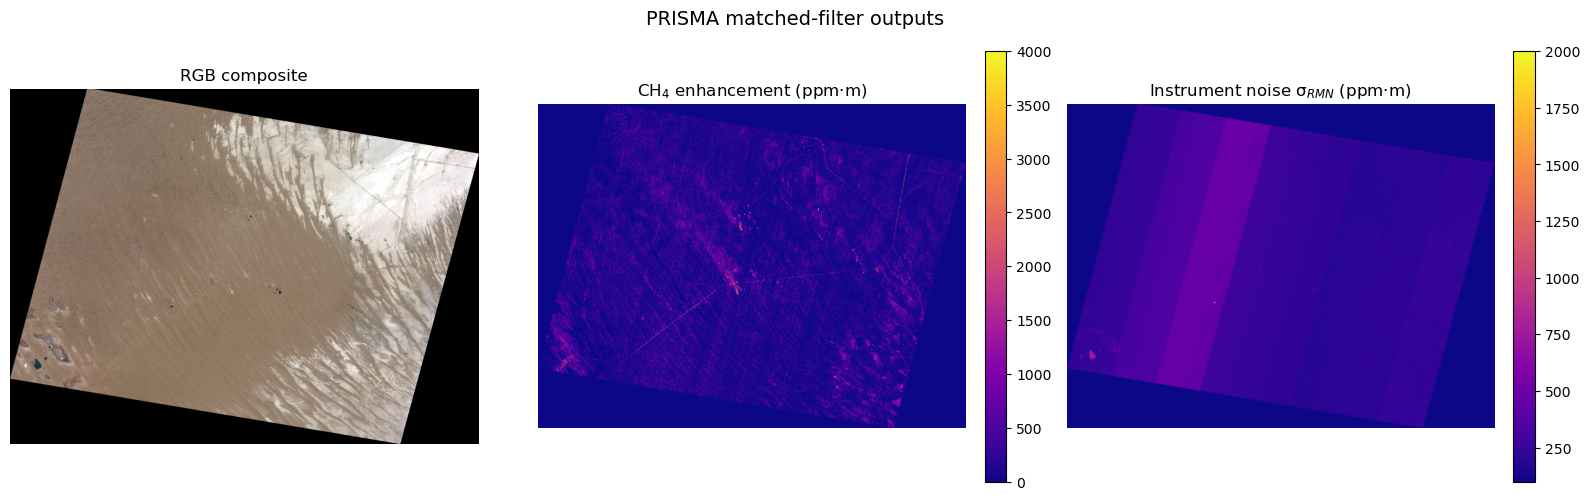

In [7]:
def _read_raster(path: Path):
    ds = gdal.Open(str(path))
    if ds is None:
        raise RuntimeError(f'Failed to open raster: {path}')
    arr = ds.ReadAsArray().astype(np.float32)
    ds = None
    return arr

basename = Path(CONFIG['l1']).stem
rgb_path = CONFIG['output_dir'] / f'{basename}_rgb.tif'
conc_path = CONFIG['output_dir'] / f'{basename}_MF_concentration.tif'
unc_path = CONFIG['output_dir'] / f'{basename}_MF_uncertainty.tif'

for label, path in [('RGB', rgb_path), ('Concentration', conc_path), ('Uncertainty', unc_path)]:
    if not path.exists():
        raise FileNotFoundError(f"Expected output not found: {path}")
    print(f"{label}: {path}")

rgb = _read_raster(rgb_path)
concentration = _read_raster(conc_path)
uncertainty = _read_raster(unc_path)

if rgb.ndim == 3:
    rgb_img = np.transpose(rgb, (1, 2, 0))
else:
    rgb_img = rgb

def _normalize_rgb(arr: np.ndarray) -> np.ndarray:
    high = np.quantile(arr, 0.995, axis=(0, 1), keepdims=True)
    high = np.clip(high, 1e-3, None)
    arr = np.clip(arr, 0, high)
    arr = arr / high
    return np.clip(arr, 0, 1)

rgb_disp = _normalize_rgb(rgb_img.astype(np.float32))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(rgb_disp)
axes[0].set_title('RGB composite')
axes[0].axis('off')

im1 = axes[1].imshow(concentration, cmap='plasma', vmin=0, vmax=4000)
axes[1].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(uncertainty, cmap='plasma', vmin=100, vmax=2000)
axes[2].set_title('Instrument noise σ$_{RMN}$ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes[1:]:
    ax.axis('off')

fig.suptitle(SENSOR.upper() + ' matched-filter outputs', fontsize=14)
plt.tight_layout()
plt.show()
